In [1]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve
from IPython.display import SVG, display
from scipy.constants import mu_0, epsilon_0

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 4: Problem 3 (p43)

## Physics Constants

In [2]:
K0 = 2 * np.pi * 3E8 * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0
print(f'Wavelength: {WAVELENGTH:.4} m')
print(f'K0^2: {K0**2:.6} 1/m')

Wavelength: 0.9993 m
K0^2: 39.5331 1/m


## 3-noded Linear Triangular Elements, $P_1$

In [3]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': None, 'name': 'circular_scatterer'}]

MATERIAL = [{'tag': 201, 'name': 'free_space', 'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 301, 'name': 'PML_a','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 302, 'name': 'PML_b','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 303, 'name': 'PML_c','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 304, 'name': 'PML_d','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 401, 'name': 'PML_I','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 402, 'name': 'PML_II','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 403, 'name': 'PML_III','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 404, 'name': 'PML_IV','relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

# Criar geometria coaxial
GEOMETRY = {'h': WAVELENGTH/10, 'L': WAVELENGTH*0.5, 'ra': WAVELENGTH*0.5, 'x0': 1.0*WAVELENGTH}
mesh_data = ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, GEOMETRY, view_mesh=False)

# Parâmetros da PML
PML_DESIGN = {
    'x0': GEOMETRY['x0'],   # Interface inicial do PML
    'n': 1.0,               # Ordem polinomial do PML
    'R': 1E-4,              # Coeficiente de reflexão
}

# Aplicar a física do problema
mesh_data = ps.apply_pml_physics(FINITE_ELEMENT, PML_DESIGN, mesh_data)

Malha salva em pre_processing/mesh/rectangular_pml_domain_Triangle1.msh
Model rectangular_pml (2D)
Info     : 51 geometric entities
Info     : 10 Physical Groups
Info     : 1105 nodes in total
Info     : 2058 2 elements in total


## Figure 1: Meshed $\Omega_c$ domain 

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p43_vectorial_circular_pec_scatterer_pml\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


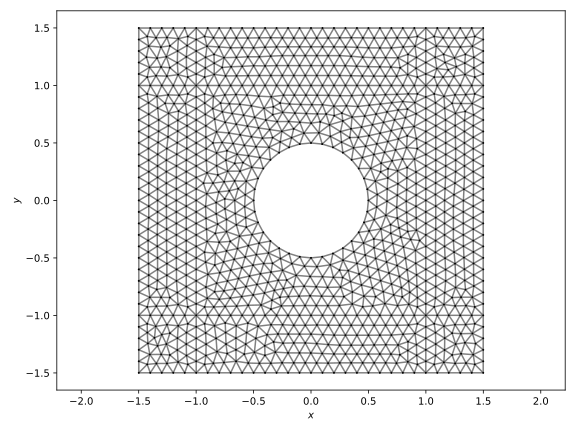

In [4]:
INFO_GRAPH = {'cell': False, 'nodes': False, 'edges': False, 'edges_numb': False}
graph_results.plot_mesh(FINITE_ELEMENT, INFO_GRAPH, mesh_data)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

## FEM Solution

## `pml_global_matrices()`

In [5]:
from scipy.sparse import lil_matrix
from fem_processing import vectorial_matrices_assembly as assembly
from fem_processing import gaussian_quadrature
from fem_processing import master_domain

# Inicializa a matriz global como uma matriz esparsa zero (tamanho NxN)
Nedges = len(mesh_data['edges'])
Sg = lil_matrix((Nedges, Nedges), dtype='complex128')
Mg = lil_matrix((Nedges, Nedges), dtype='complex128')
bg = lil_matrix((Nedges, 1), dtype='complex128')

# Início do processo de montagem
for cell in mesh_data['cell'].values(): 

    # Initialize the local matrices
    Ne = len(cell['conn_edge'])
    
    # Se = np.zeros((Ne, Ne), dtype='complex128') # Matriz de rigidez do elemento
    Me = np.zeros((Ne, Ne), dtype='complex128') # Matriz de massa do elemento
    be = np.zeros((Ne, 1), dtype='complex128')  # Vetor de carga do elemento

    # Get the Gauss points and weights
    gauss_points, gauss_weights = gaussian_quadrature.gauss_data(FINITE_ELEMENT)

    # Cálculo da matriz Jacobiana
    # Je = cell['geo']['jacobian']
    Je = assembly.jacobian(mesh_data, cell)

    # Determinante e inversa transposta do Jacobiano
    Jdet, JinvT = np.abs(np.linalg.det(Je)), np.linalg.inv(Je).T  

    # Material properties
    pe = cell['p(x)']
    qe = cell['q(x)']
    fe = cell['f(x)']

    # Matriz de rigidez do elemento
    Se = 2 / Jdet * np.array([
        [1, -1, 1], 
        [-1, 1, -1],
        [1, -1, 1]
    ])

    # Coordenadas do centroide do elemento
    xc, yc = cell['geo']['centroid']
    
    # Integração numérica
    for xik, wk in zip(gauss_points, gauss_weights):
        # Função de forma vetorial no ponto de integração
        phi_hat = master_domain.shape_functions_n0(*xik)

        # Montagem da matriz de massa
        for i in range(Ne):
            # Transformação de Piola Covariante
            phi_i = (JinvT @ phi_hat[i])

            for j in range(Ne):
                # Transformação de Piola Covariante
                phi_j = JinvT @ phi_hat[j]
                
                # Matriz de massa
                Me[i, j] += (phi_i.T @ phi_j).item() * Jdet * wk

    ## Sg, Mg, bg = ps.pml_global_matrices(FINITE_ELEMENT, mesh_data)
    # loop sobre os nós locais de cada elemento
    for i, ig in enumerate(cell['conn']):
        ig = int(ig)-1
        for j, jg in enumerate(cell['conn']):
            jg = int(jg)-1
            Sg[ig, jg] += Se[i, j]
            Mg[ig, jg] += Me[i, j]
            
        # preenche o vetor global b
        bg[ig, 0] += be[i, 0]

## `apply_simple_dirichlet()`

In [6]:
for key, edge in mesh_data['edges'].items():
    # Verifica se a aresta é de Dirichlet
    if edge['bc']['type'] == 'Dirichlet':
        e = int(key) - 1
        
        # Zera a linha correspondente a aresta de Dirichlet
        Sg[e, :] = 0
        # Mg[e, :] = 0

        # Define o valor 1 na diagonal para evitar singularidade
        Sg[e, e] = 1
        # Mg[e, e] = 0.5
        
        # Ajusta o vetor de forças com o valor de Dirichlet
        bg[e] = - edge['bc']['value']

In [7]:
# Solução do problema matricial
uh = spsolve((Sg + Mg).tocsr(), bg.toarray())

# Dicionário com os resultados numéricos
ezh = {key+1: value for key, value in enumerate(uh)}

C:\Users\adilt\AppData\Local\Temp\ipykernel_5168\2951084688.py:2: MatrixRankWarning: Matrix is exactly singular
  uh = spsolve((Sg + Mg).tocsr(), bg.toarray())


## Interpolate solution

In [8]:
# Dicionário para armazenar os potenciais vetoriais interpolados em cada célula
uh_at_cell = {}
xik_master = (1/3, 1/3)

# Percorre cada célula da malha
for key, cell in mesh_data['cell'].items(): 
    Je = assembly.jacobian(mesh_data, cell)    
    JinvT = np.linalg.inv(Je).T
    phi_hat = master_domain.shape_functions_n0(*xik_master)

    # Interpolação dos potenciais vetoriais em cada célula
    uh_at_cell[key] = 0
    for i, edge in enumerate(cell['conn_edge']):
        uh_at_cell[key] += ezh[edge].real * (JinvT @ phi_hat[i])

## Figure 2: Numerical solution to scattered electric field, $E_z^s$, at $\Omega_c$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p43_vectorial_circular_pec_scatterer_pml\pos_processing\pictures\vectorial_fem_solution_Triangle1_EntireDomain.svg


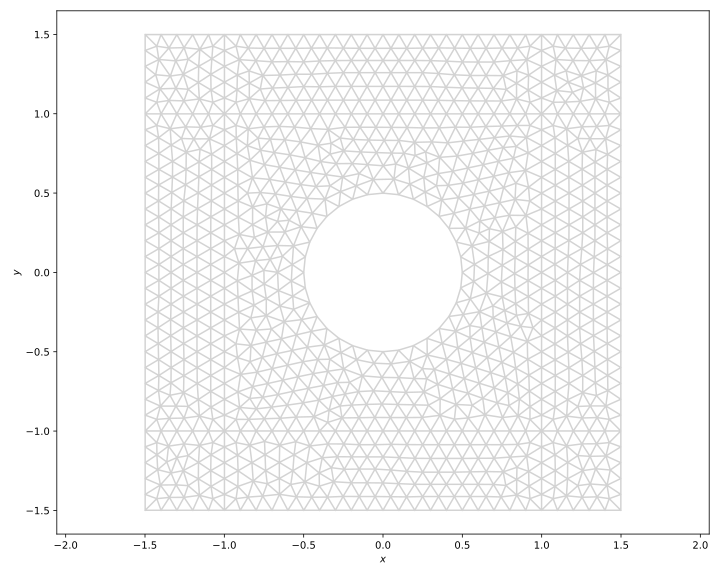

In [9]:
graph_results.vectorial_fem_solution(FINITE_ELEMENT, mesh_data, uh_at_cell)
display(SVG(filename="pos_processing/pictures/vectorial_fem_solution_Triangle1_EntireDomain.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.